In [564]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score as accuracy

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


import torch
from torch.utils.data import DataLoader

import joblib
from collections import Counter

colors = sns.color_palette("rocket")
colors

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [565]:
df = pd.read_csv('/Users/nazarlenisin/Desktop/Multi-Class Classification /Train.csv')
df.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B


In [566]:
class Prior_Data_Analys:
  def __init__(self,df):
    self.df = df


  def shape(self):
    n_samples,n_columns = self.df.shape
    print(f'Number of samples in Data Set: {n_samples}')
    print(f'Number of columns: {n_columns}')

    return n_samples,n_columns


  def unique_columns(self):
    columns = self.df.columns
    print(f'Unique columns:\n')

    for column_idx,column in enumerate(columns):
      print(f'Column {column_idx + 1}: {column}')

    return columns


  def columns_dtypes(self):
    dtypes = self.df.dtypes
    print(f'Dtypes:\n\n {dtypes}')

    return dtypes


  def categorical_features(self):
    print(f'Categorical features:\n')
    categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']

    for feature in categorical_feats:
      print(f'* {feature}')

    return np.array(categorical_feats)


  def numerical_features(self):
    print(f'Numerical features: \n')

    numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
    for feature in numerical_feats:
      print(f'* {feature}')

    return np.array(numerical_feats)


  def group_by(self,feature):
    categorical = self.categorical_features()

    if feature in categorical:
      return df.groupby([feature]).count()

    else:
      return df.groupby([feature]).describe()


  def count_NA(self):
    print(f'Amout of Nans per class:')
    return self.df.isna().sum()


  def duplicates(self):
    print(f'Amount of duplicates: {self.df.duplicated().sum()}')

  def item(self,index):
    print(f'Object number: {index}')

    return self.df.iloc[index]

  def unique_values(self,feature):
    data = self.df[feature]

    values = data.values
    unique_values = np.unique(values)
    print(f'Unique values of {feature}: {unique_values}')

    return unique_values

In [567]:
class Distribution:
  def __init__(self,df,target_feature):
    self.df = df
    self.target_feature = target_feature
    self._eda = Prior_Data_Analys(self.df)


  def distribution_of_target_feature(self):
    for visualization in range(2):
      plt.figure(figsize = (10,10))
      plt.subplot(2,1,visualization + 1)
      if visualization == 0:
        sns.histplot(data = self.df,x = self.target_feature,color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()

      else:
        sns.boxplot(x = self.df[self.target_feature],color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()


  def distribution_of_numerical_features(self):
    numerical_features = self._eda.numerical_features()

    for feature_idx,feature in enumerate(numerical_features):
      plt.figure(figsize = (15,15))
      plt.subplot(len(numerical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.histplot(data = self.df,x = feature,color = colors[1])
      plt.title(f'Distibution of {feature}')
      plt.tight_layout
      plt.show()


  def distribution_of_categorical_features(self,top_k = 5):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      values = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).values[:top_k]
      labels = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).index[:top_k]

      data_dict = {'Labels': labels, 'Values': values}
      data = pd.DataFrame(data_dict)

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.barplot(data = data,y = 'Labels',x = 'Values',color = colors[-1])
      plt.title(f'Top {top_k} {feature} by count')

    plt.tight_layout()
    plt.show()

  def relation_numerical_feats_to_target_feat(self):
    numerical_features = self._eda.numerical_features()

    data = df[numerical_features]
    corr = data.corr()

    return sns.heatmap(corr,annot = True, cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

  def relation_categorical_feats_to_target_feat(self,top_k = 3):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      feats = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False)[:top_k].index

      data = self.df
      data = data[data[feature].isin(feats)]

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.stripplot(data = data, x = feature, y = self.target_feature,hue = feature)
      plt.title(f'Relation between {feature} (top {top_k}) & {self.target_feature}')

    plt.tight_layout()
    plt.show()

In [568]:
class Data_Preprocessing:
  def __init__(self,df,target_feature = None):
    self.df = df
    self.target_feature = target_feature

  def _feature_target_split(self):
    if self.target_feature != None:
      X = self.df[[feature for feature in self.df.columns if feature != self.target_feature]]
      y = self.df[self.target_feature]
      return X,y

    else:
      X = self.df
      return X

  def _one_hot(self,X):
    ohe = OneHotEncoder(handle_unknown = 'ignore',sparse_output = False).set_output(transform = 'pandas')

    return ohe.fit_transform(X)

    return X

  def _normalize(self,X):
    X = normalize(X)
    return X


  def transform(self):
    if self.target_feature != None:
      numerical_features = eda.numerical_features()
      numerical_features = list(numerical_features)
      numerical_features.remove(self.target_feature)
      numerical_features = np.array(numerical_features)

      categorical_features = eda.categorical_features()

      X,y = self._feature_target_split()
      X,y = X.fillna(value = 0),y.fillna(value = 'Nan')

      X_num = self._normalize(X[numerical_features].astype(np.float64))
      X_cat = self._one_hot(X[categorical_features].astype('str'))

      X_num = pd.DataFrame(X_num,columns = numerical_features)
      X_cat = pd.DataFrame(X_cat)

      X = pd.concat([X_num,X_cat],axis = 1)

      return X,y

    else:
      numerical_features = [column for column in self.df.columns if self.df[column].dtype != 'O']
      categorical_features = eda.categorical_features()

      X = self._feature_target_split()
      X = X.fillna(value = 0)

      X_num = self._normalize(X[numerical_features].astype(np.float64))
      X_cat = self._one_hot(X[categorical_features].astype('str'))

      X_num = pd.DataFrame(X_num,columns = numerical_features)
      X_cat = pd.DataFrame(X_cat)

      X = pd.concat([X_num,X_cat],axis = 1)

      return X

In [569]:
class OneVsRestClassifier:
  def __init__(self,model):
    self.model = model
    self._fit_models = []

  def fit(self,X,y):
    #X = X.values
    #y = y.values
    labels = np.unique(y)

    for label in labels:
      binary_y = np.where(y == label,1,0)

      fit_model = self.model.fit(X,binary_y)
      self._fit_models.append(joblib.dump(fit_model,f'_ova{label}_'))

  def predict(self,X):
    predictions = []

    for model_idx,_ in enumerate(self._fit_models):
      model = joblib.load(f'ova{model_idx}')

      prediction = np.array(model.predict_proba(X)[:,1])
      predictions.append(prediction)

    predictions = np.array(predictions)
    predictions = np.array([predictions[:,element_idx] for element_idx in range(predictions.shape[1])])

    pred_labels = np.argmax(predictions,1)

    return pred_labels

In [570]:
class OneVsOneClassifier:
  def __init__(self,model):
    self.model = model
    self._fit_models = []

  def _most_common(self,y):
    counter = Counter(y)
    value = counter.most_common(1)[0][0]
    return value

  def _hypotesis(self,labels):
    hypotesis = []
    labels = [i for i in range(len(labels))]

    x1 = 0
    x2 = 1

    while x1 <= len(labels) - 2:
      while x2 <= len(labels) - 1:
        hypotesis.append((x1,x2))
        x2 += 1
      x1 += 1
      x2 = x1 + 1

    return hypotesis


  def fit(self,X,y):
    X = X.values
    y = y.values

    labels = np.unique(y)

    n = len(labels)

    n_hypotesis = int((n * (n - 1)) / 2)
    self.hypotesis = self._hypotesis(labels)

    for hypotes_idx,hypotes in enumerate(self.hypotesis):

      x1 = labels[hypotes[0]]
      x2 = labels[hypotes[1]]

      idxs = np.array([target_idx for target_idx,target in enumerate(y) if (target == x1 or target == x2)])

      X_train = X[idxs]
      y_train = y[idxs]

      y_train = np.where(y_train == x1,0,1)

      fit_model = self.model.fit(X_train,y_train)
      self._fit_models.append(joblib.dump(fit_model,f'_ovo{hypotes_idx}'))


  def predict(self,X):
    predictions = []

    for model_idx,_ in enumerate(self._fit_models):
      model = joblib.load(f'ovo{model_idx}')

      prediction = np.array(model.predict_proba(X)[:,1])
      predictions.append(prediction)

    predictions = np.array(predictions)
    predictions = np.array([predictions[:,element_idx] for element_idx in range(predictions.shape[1])])
    predictions = np.array([np.where(prediction <= 0.5, 0 , 1) for prediction in predictions])

    for prediction_idx,prediction in enumerate(predictions):
      for label_prediction_idx,label_prediction in enumerate(prediction):
        if label_prediction == 0:
          predictions[prediction_idx,label_prediction_idx] = self.hypotesis[label_prediction_idx][0]
        else:
          predictions[prediction_idx,label_prediction_idx] = self.hypotesis[label_prediction_idx][1]

    labels = np.array([self._most_common(classes) for classes in predictions])

    return labels

In [571]:
class Train_Model:
  def __init__(self,model):
    self.model = model
    self._fit_models = []

  def fit(self,X,y):
    ova_model = OneVsRestClassifier(self.model)
    ovo_model = OneVsOneClassifier(self.model)

    ova_model.fit(X,y)
    ovo_model.fit(X,y)

    self._fit_models.append(ova_model)
    self._fit_models.append(ovo_model)

    ova_prediction = ova_model.predict(X)
    ovo_prediction = ovo_model.predict(X)

    ova_acc = accuracy(y,ova_prediction)
    ovo_acc = accuracy(y,ovo_prediction)

    print(f'{self.model} (OneVsRestClassifier) Accuracy on Train Data: {ova_acc}')
    print(f'{self.model} (OneVsOneClassifier) Accuracy on Train Data: {ovo_acc}\n\n')

    return ova_model,ovo_model

  def eval(self,X,y):
    ova_model = self._fit_models[0]
    ovo_model = self._fit_models[1]

    ova_prediction = ova_model.predict(X)
    ovo_prediction = ovo_model.predict(X)

    ova_acc = accuracy(y,ova_prediction)
    ovo_acc = accuracy(y,ovo_prediction)

    print(f'\n{self.model} (OneVsRestClassifier) Accuracy on Test Data: {ova_acc}')
    print(f'{self.model} (OneVsOneClassifier) Accuracy on Test Data: {ovo_acc}')

    if ova_acc == ovo_acc:
      return ova_model,ova_acc

    else:
      highest_score = np.argmax(np.array([ova_acc,ovo_acc]))
      return self._fit_models[highest_score],np.max(np.array([ova_acc,ovo_acc]))

In [572]:
class Optimal_Model:
  def __init__(self,models,X_train,y_train,X_test,y_test):
    self.models = models
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.optimal_models = []
    self.accuracy_scores = []

  def optimal(self):
    for model in self.models:
      print(f'\nModel: {model}')

      Trainer = Train_Model(model)
      Trainer.fit(self.X_train,self.y_train)

      optimal_model,accuracy_score = Trainer.eval(self.X_test,self.y_test)
      self.optimal_models.append(optimal_model)
      self.accuracy_scores.append(accuracy_score)

    highest_acc = np.argmax(np.array(self.accuracy_scores))

    return self.optimal_models[highest_acc]

In [573]:
def Predict(model,X):
  data_preprocessing = Data_Preprocessing(X)
  X = data_preprocessing.transform()

  predictions = model.predict(X)
  predictions = [inverse_vocab[prediction] for prediction in predictions]

  return np.array(predictions)

In [574]:
target_feature = 'Segmentation'

eda = Prior_Data_Analys(df)
data_visualization = Distribution(df,target_feature = target_feature)
data_preprocessing = Data_Preprocessing(df,target_feature = target_feature)

In [575]:
labels = list(eda.unique_values(target_feature))

vocab = {label: label_idx for label_idx,label in enumerate(labels)}
inverse_vocab = {label_idx: label for label,label_idx in vocab.items()}

Unique values of Segmentation: ['A' 'B' 'C' 'D']


In [576]:
for label,label_idx in vocab.items():
  print(f'Label: {label} | Label idx: {label_idx}')
  df[target_feature] = df[target_feature].replace(to_replace = label, value = label_idx)

Label: A | Label idx: 0
Label: B | Label idx: 1
Label: C | Label idx: 2
Label: D | Label idx: 3


In [577]:
eda.shape()

Number of samples in Data Set: 8068
Number of columns: 11


(8068, 11)

In [578]:
eda.unique_columns()

Unique columns:

Column 1: ID
Column 2: Gender
Column 3: Ever_Married
Column 4: Age
Column 5: Graduated
Column 6: Profession
Column 7: Work_Experience
Column 8: Spending_Score
Column 9: Family_Size
Column 10: Var_1
Column 11: Segmentation


Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [579]:
eda.columns_dtypes()

Dtypes:

 ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation         int64
dtype: object


ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation         int64
dtype: object

In [580]:
eda.categorical_features()

Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ tre

array(['Gender', 'Ever_Married', 'Graduated', 'Profession',
       'Spending_Score', 'Var_1'], dtype='<U14')

In [581]:
eda.numerical_features()

Numerical features: 

* ID
* Age
* Work_Experience
* Family_Size
* Segmentation


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:44: FutureWarning: Series.__getitem__ treatin

array(['ID', 'Age', 'Work_Experience', 'Family_Size', 'Segmentation'],
      dtype='<U15')

In [582]:
eda.count_NA()

Amout of Nans per class:


ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [583]:
eda.duplicates()

Amount of duplicates: 0


In [584]:
eda.unique_values(target_feature)

Unique values of Segmentation: [0 1 2 3]


array([0, 1, 2, 3])

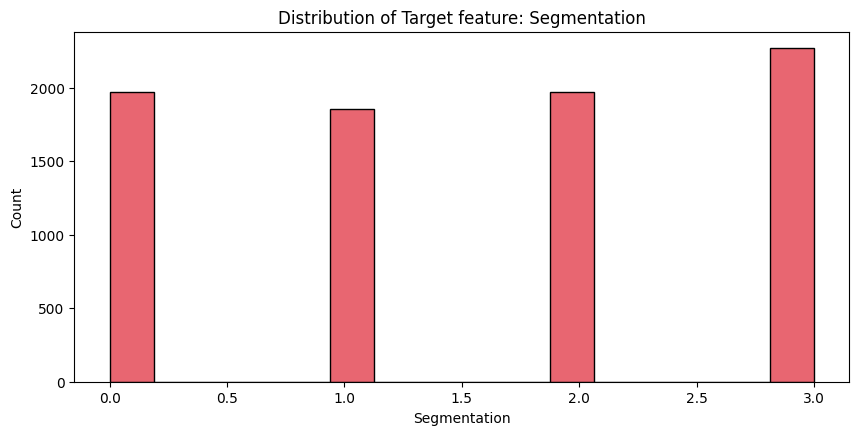

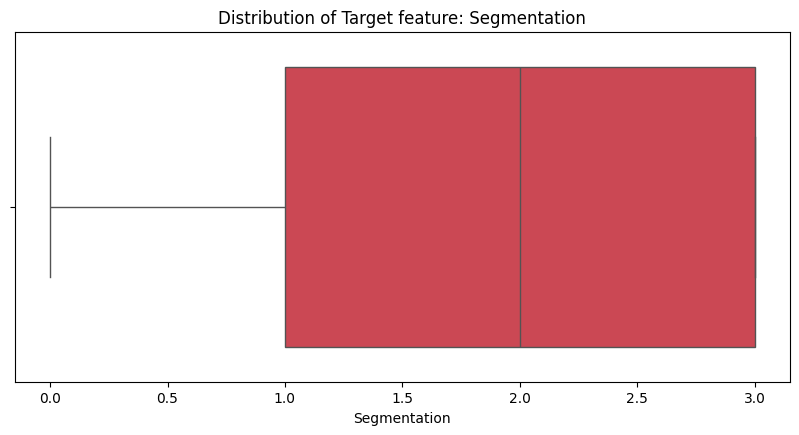

In [585]:
data_visualization.distribution_of_target_feature()

Numerical features: 

* ID
* Age
* Work_Experience
* Family_Size
* Segmentation


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:44: FutureWarning: Series.__getitem__ treatin

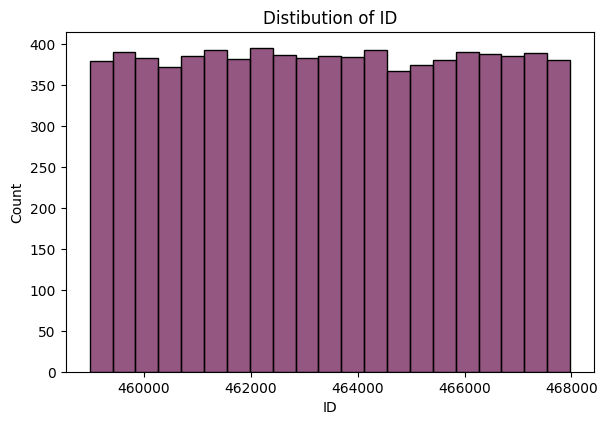

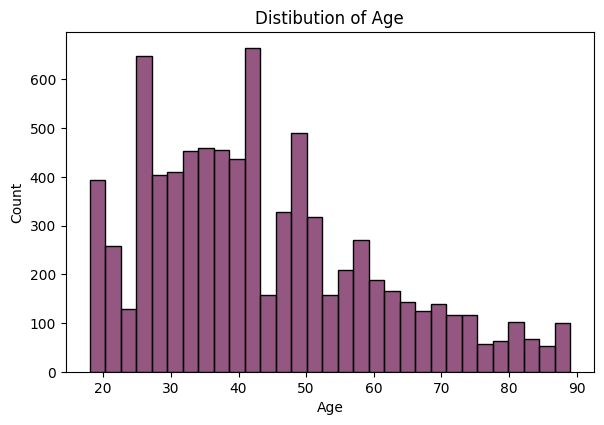

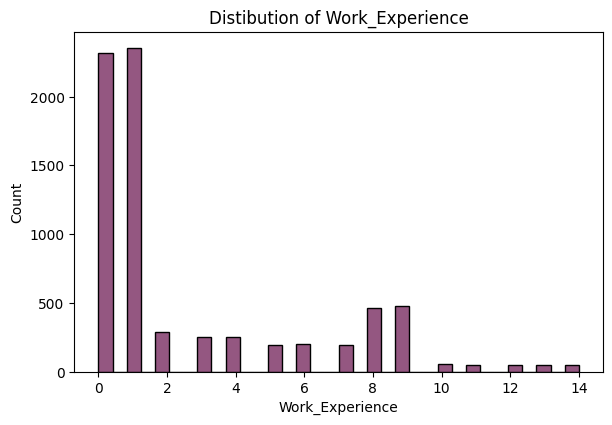

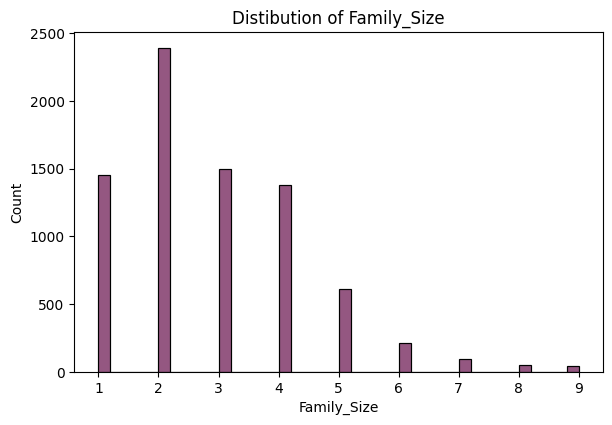

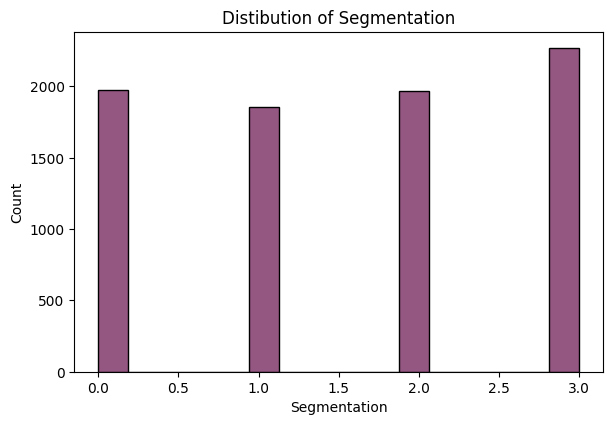

In [586]:
data_visualization.distribution_of_numerical_features()

Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gende

/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ tre

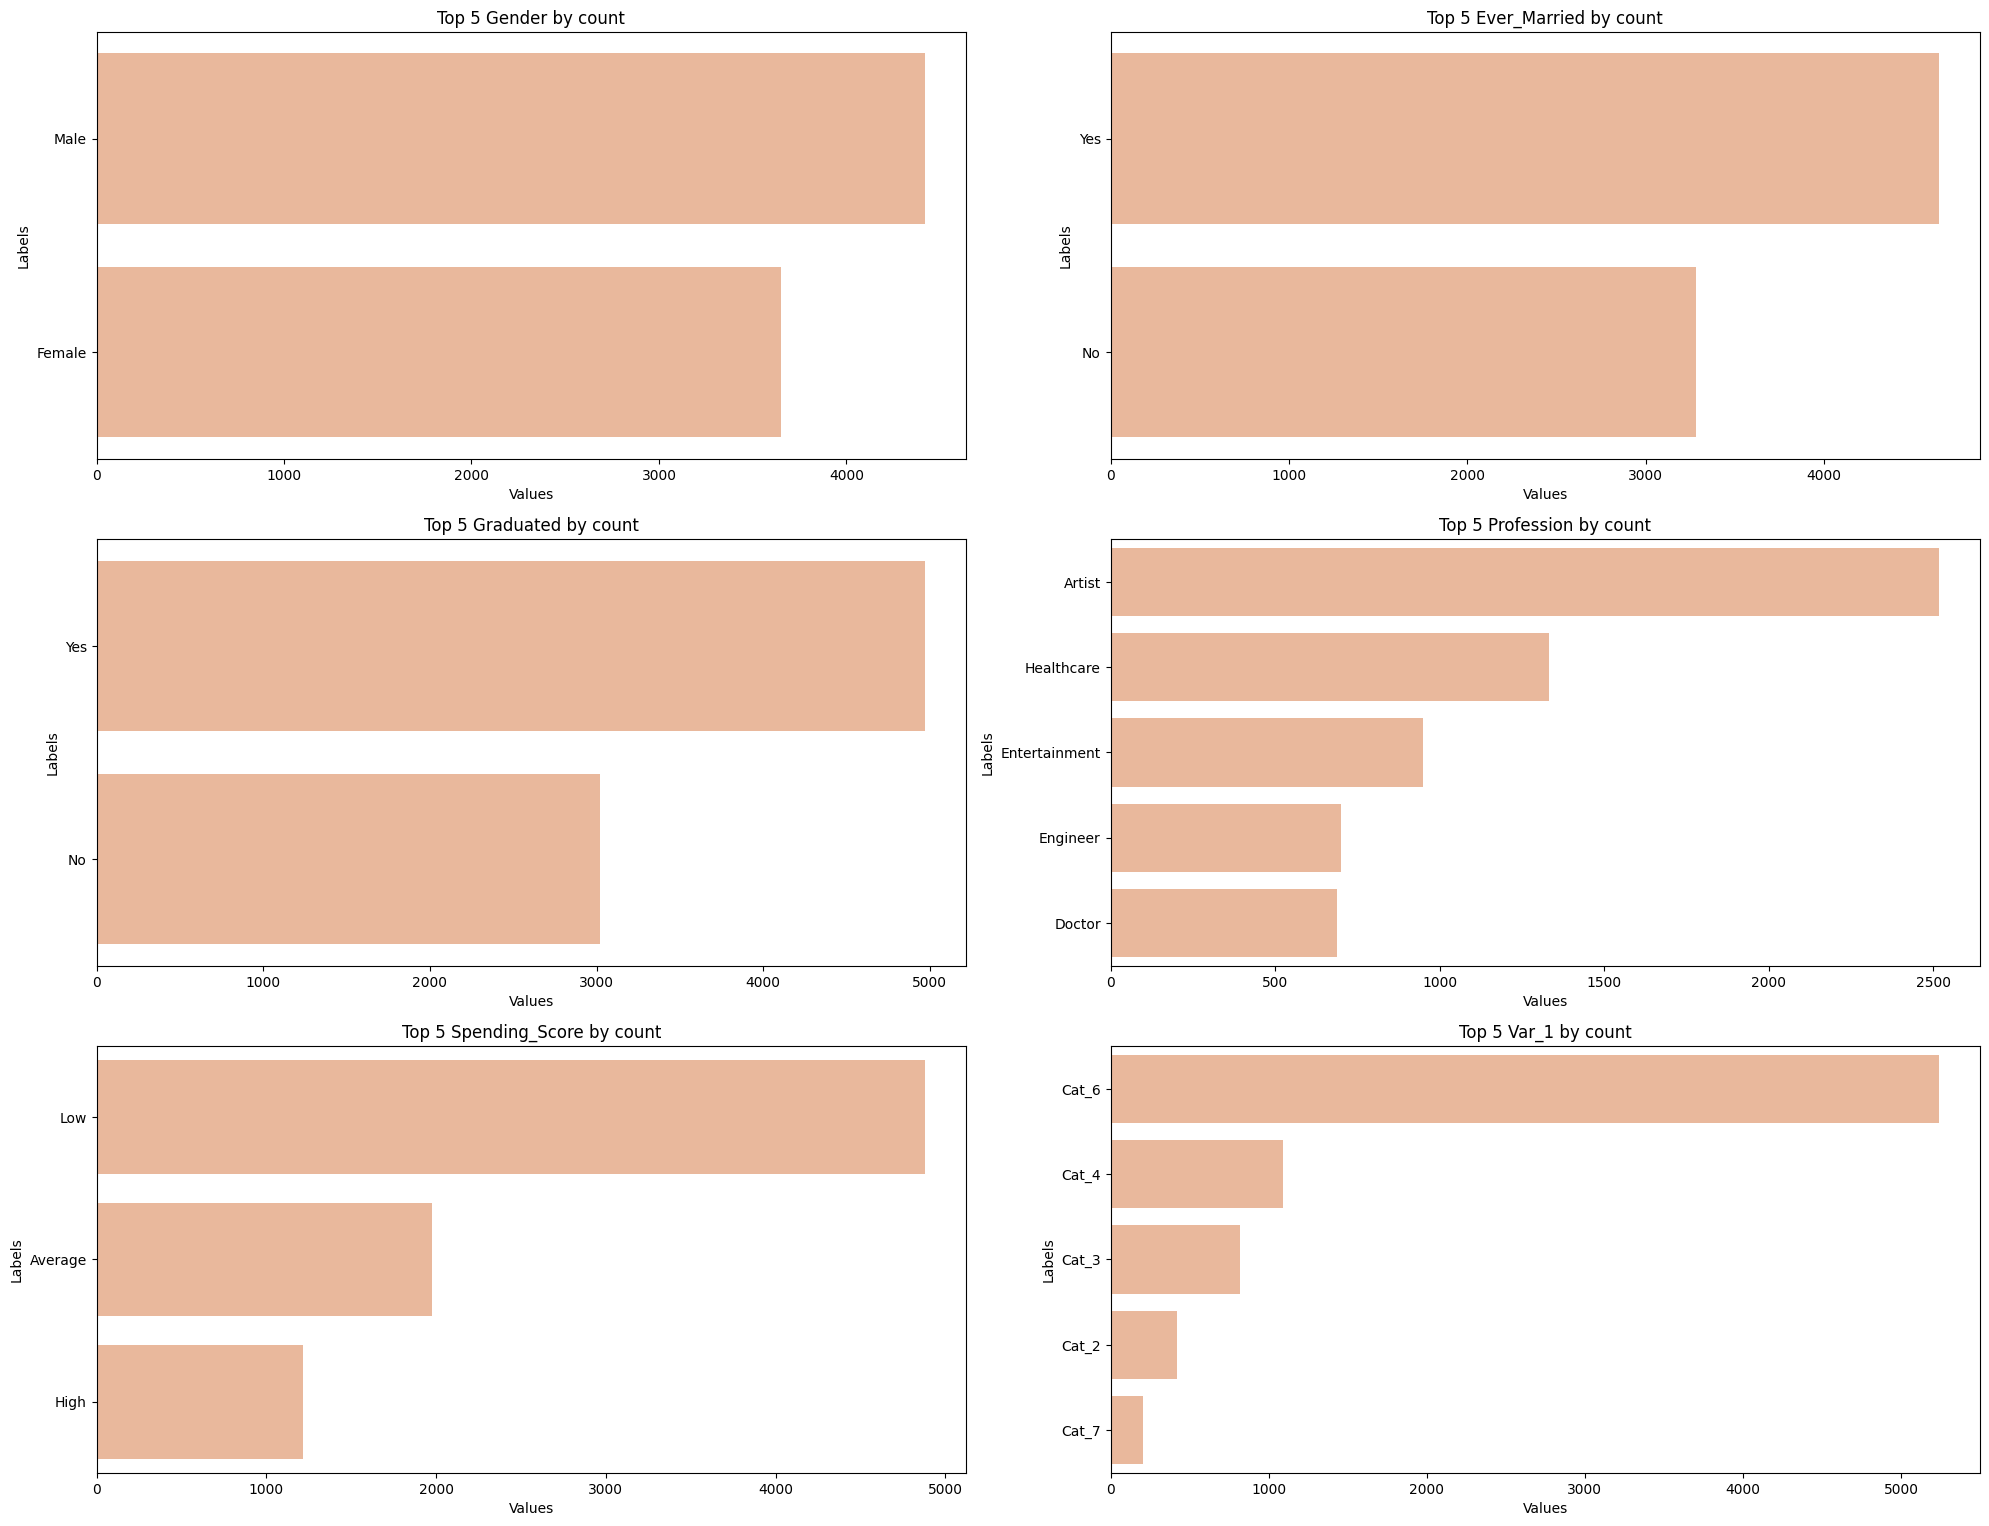

In [587]:
data_visualization.distribution_of_categorical_features()

Numerical features: 

* ID
* Age
* Work_Experience
* Family_Size
* Segmentation


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:44: FutureWarning: Series.__getitem__ treatin

<Axes: >

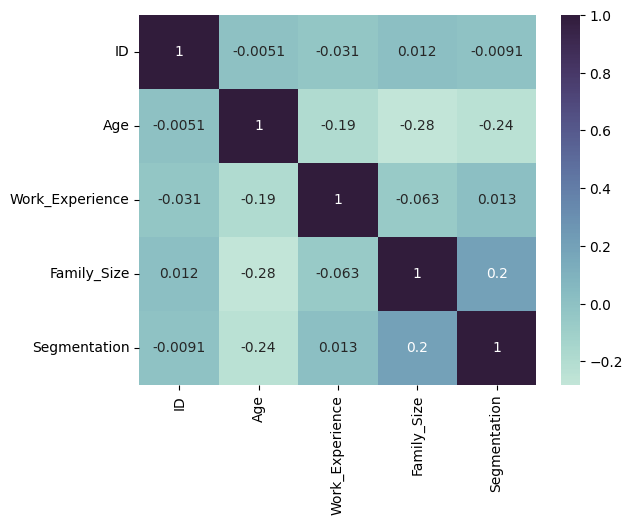

In [588]:
data_visualization.relation_numerical_feats_to_target_feat()

Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ tre

Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ tre

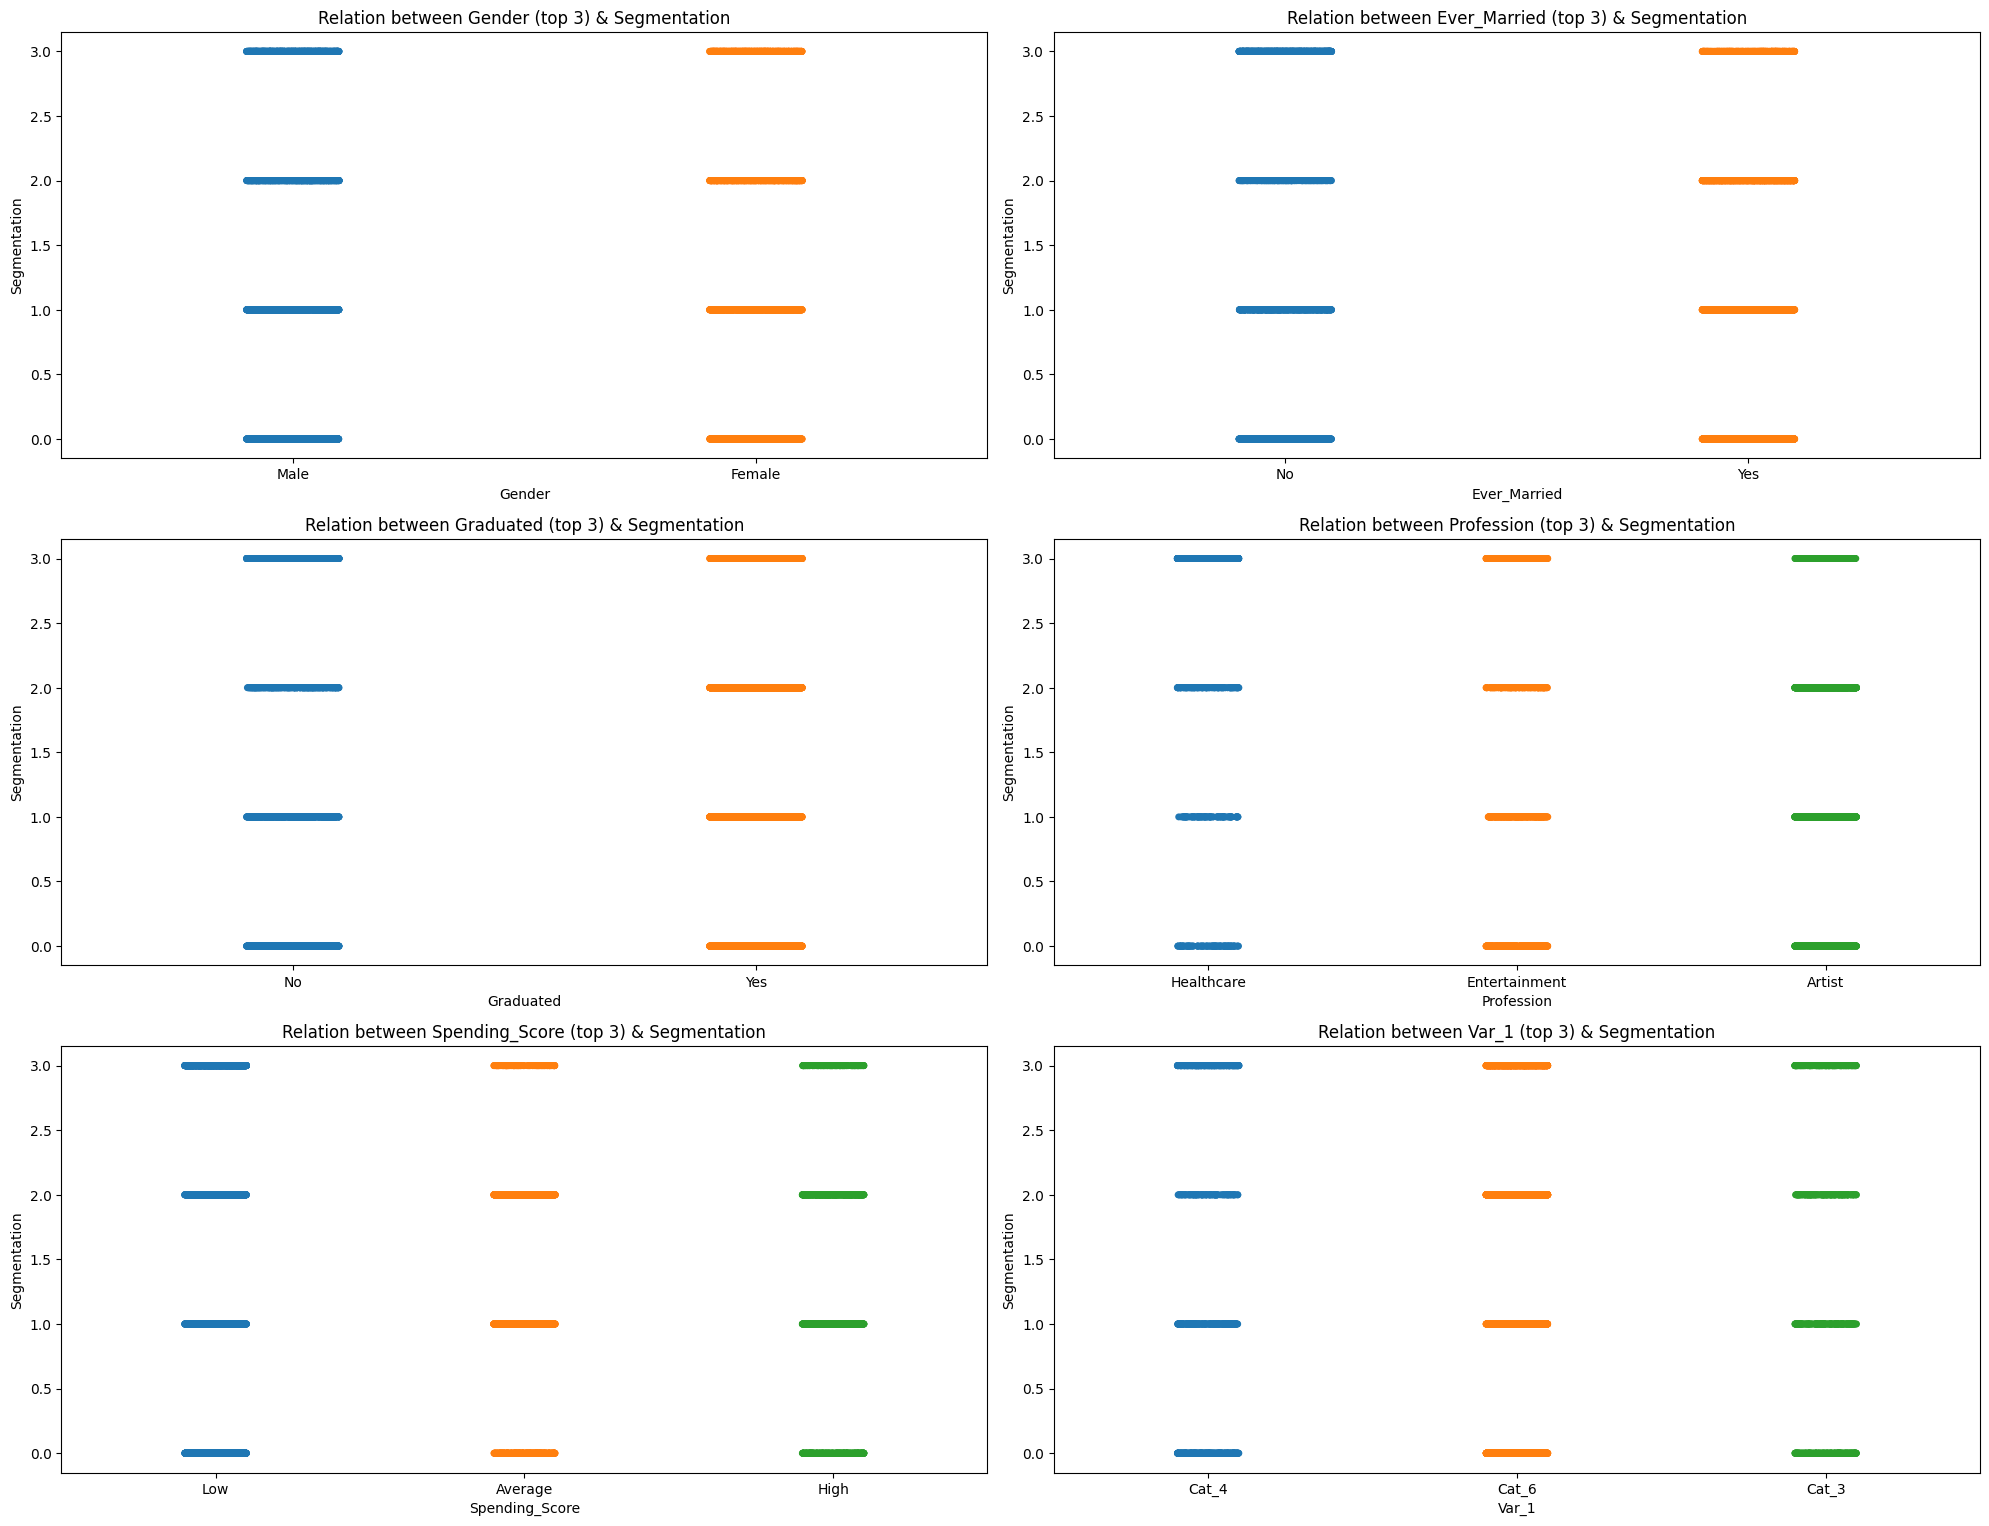

In [589]:
data_visualization.relation_categorical_feats_to_target_feat()

In [590]:
data_preprocessing = Data_Preprocessing(df,target_feature = target_feature)

X,y = data_preprocessing.transform()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

Numerical features: 

* ID
* Age
* Work_Experience
* Family_Size
* Segmentation
Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:44: FutureWarning: Series.__getitem__ treatin

In [591]:
logistic_regression = LogisticRegression()
naive_bayes = GaussianNB()
svc = SVC(probability = True)
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
xgb_classifier = XGBClassifier()

models = [logistic_regression,naive_bayes,svc,decision_tree,random_forest,xgb_classifier]

In [592]:
Optimal = Optimal_Model(models,X_train,y_train,X_test,y_test)
optimal_model = Optimal.optimal()


Model: LogisticRegression()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted

LogisticRegression() (OneVsRestClassifier) Accuracy on Train Data: 0.896343352959405
LogisticRegression() (OneVsOneClassifier) Accuracy on Train Data: 0.5088317322590642



LogisticRegression() (OneVsRestClassifier) Accuracy on Test Data: 0.5154894671623296
LogisticRegression() (OneVsOneClassifier) Accuracy on Test Data: 0.4876084262701363

Model: GaussianNB()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted

GaussianNB() (OneVsRestClassifier) Accuracy on Train Data: 0.896343352959405
GaussianNB() (OneVsOneClassifier) Accuracy on Train Data: 0.5088317322590642



GaussianNB() (OneVsRestClassifier) Accuracy on Test Data: 0.5154894671623296
GaussianNB() (OneVsOneClassifier) Accuracy on Test Data: 0.4876084262701363

Model: SVC(probability=True)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted

SVC(probability=True) (OneVsRestClassifier) Accuracy on Train Data: 0.896343352959405
SVC(probability=True) (OneVsOneClassifier) Accuracy on Train Data: 0.5088317322590642



SVC(probability=True) (OneVsRestClassifier) Accuracy on Test Data: 0.5154894671623296
SVC(probability=True) (OneVsOneClassifier) Accuracy on Test Data: 0.4876084262701363

Model: DecisionTreeClassifier()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted

DecisionTreeClassifier() (OneVsRestClassifier) Accuracy on Train Data: 0.896343352959405
DecisionTreeClassifier() (OneVsOneClassifier) Accuracy on Train Data: 0.5088317322590642



DecisionTreeClassifier() (OneVsRestClassifier) Accuracy on Test Data: 0.5154894671623296
DecisionTreeClassifier() (OneVsOneClassifier) Accuracy on Test Data: 0.4876084262701363

Model: RandomForestClassifier()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted

RandomForestClassifier() (OneVsRestClassifier) Accuracy on Train Data: 0.896343352959405
RandomForestClassifier() (OneVsOneClassifier) Accuracy on Train Data: 0.5088317322590642



RandomForestClassifier() (OneVsRestClassifier) Accuracy on Test Data: 0.5154894671623296
RandomForestClassifier() (OneVsOneClassifier) Accuracy on Test Data: 0.4876084262701363

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
     

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) (OneVsRestClassifier) Accuracy on Train Data: 0.896343352959405
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_

In [593]:
data = df[[column for column in df.columns if column != target_feature]]

prediction = Predict(optimal_model,data)
print(f'\n\nPredictions: {prediction}')

Categorical features:

* Gender
* Ever_Married
* Graduated
* Profession
* Spending_Score
* Var_1


Predictions: ['D' 'B' 'B' ... 'D' 'C' 'B']


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_11149/4263177674.py:33: FutureWarning: Series.__getitem__ tre